# MoeDPExperts

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import torch

class First:
    def __init__(self):
        self.per = 5
        
class Sencond:
    def __init__(self):
        self.first = First()
        
s = Sencond()
setattr(s, "first.per", 6)
s.first.per

5

In [110]:
def plot_gpu_memory(df, data_parallel_value=3.512, title='GPU Memory Usage: MoE vs Data Parallelism'):
    data_parallel = [data_parallel_value] * len(df)

    plt.figure(figsize=(8, 5))
    plt.plot(data_parallel, label='Data parallelism', color='red', linestyle='--', linewidth=2)
    plt.plot(df['max_memory_gpu_0'], label='MoE GPU 0', color='orange', linewidth=2)
    plt.plot(df['max_memory_gpu_1'], label='MoE GPU 1', color='green', linewidth=2)

    plt.title(title)
    plt.xlabel('Snapshot')
    plt.ylabel('Max GPU memory (GB)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [111]:
def plot_gpu_memory_ratio(df, data_parallel_value=3.512, title='MoE / Data Parallel GPU Memory Ratio'):

    data_parallel = [data_parallel_value] * len(df)

    ratio_gpu_0 = [p / s for p, s in zip(df['max_memory_gpu_0'], data_parallel)]
    ratio_gpu_1 = [p / s for p, s in zip(df['max_memory_gpu_1'], data_parallel)]
    ratio_average = [(p1 + p2) / (2 * s) for p1, p2, s in zip(df['max_memory_gpu_0'], df['max_memory_gpu_1'], data_parallel)]

    plt.figure(figsize=(8, 5))
    plt.plot(ratio_gpu_0, label='MoE GPU 0', color='orange', linewidth=2)
    plt.plot(ratio_gpu_1, label='MoE GPU 1', color='green', linewidth=2)
    plt.plot(ratio_average, label='Average', color='blue', linewidth=2, linestyle='--')

    plt.title(title)
    plt.xlabel('Snapshot')
    plt.ylabel('Max GPU memory ratio (MoE / Data Parallel)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [75]:
def plot_k_time(k_values, times, title='Data Parallel vs MoE Parallel — Execution Time'):

    times = np.array(times)
    data_parallel = times[:, 0]
    moe_parallel = times[:, 1]
    x = np.arange(len(k_values))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 5))

    bars1 = ax.bar(x - width/2, data_parallel, width, label='Data parallel', color='skyblue')
    bars2 = ax.bar(x + width/2, moe_parallel, width, label='MoE parallel', color='lightcoral')
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.02,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9
            )
    ax.set_xticks(x)
    ax.set_xticklabels([f'k={k}' for k in k_values])
    ax.set_ylabel('Time (s)')
    ax.set_title(title)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


## Неравномерное распределение

In [112]:
df = pd.read_csv("results.csv")
df['time'] = df['time'] - df['time'].iloc[0]

In [113]:
df

,name,time,memory_gpu_0,max_memory_gpu_0,memory_gpu_1,max_memory_gpu_1
0,start,0.000000,0.882998,0.883001,0.882998,0.883001
1,start forward,0.002577,0.509525,0.882999,0.509525,0.882999
2,full top k index,0.004420,0.510014,0.510016,0.510014,0.510016
3,final hidden states,0.005937,0.635015,0.635017,0.635015,0.635017
4,sort global ranks,0.026871,0.635748,0.636497,0.635748,0.636497
5,need indicies,0.031667,0.635909,0.636343,0.635835,0.636195
6,local sorted ranks,0.032946,0.636154,0.636533,0.636080,0.636459
7,bincount,0.051725,0.636155,0.636158,0.636081,0.636084
8,recv counts,0.052890,0.636157,0.636159,0.636083,0.636085
9,counts.tolist,0.054482,0.636157,0.636295,0.636083,0.636221


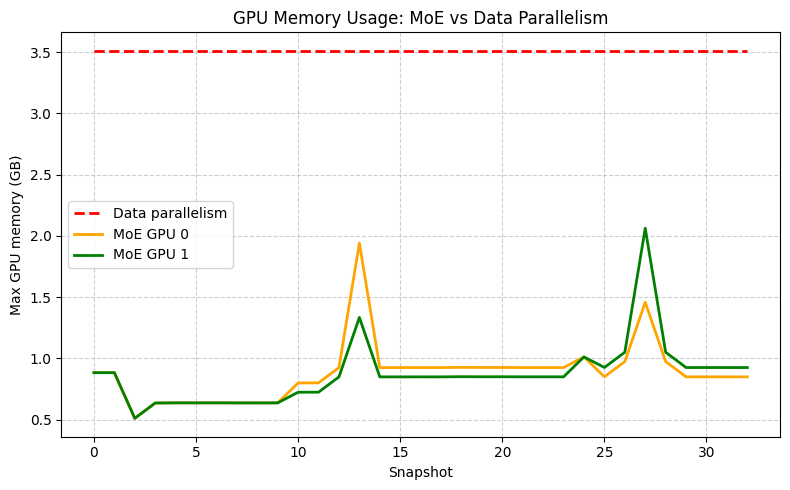

In [114]:
plot_gpu_memory(df)

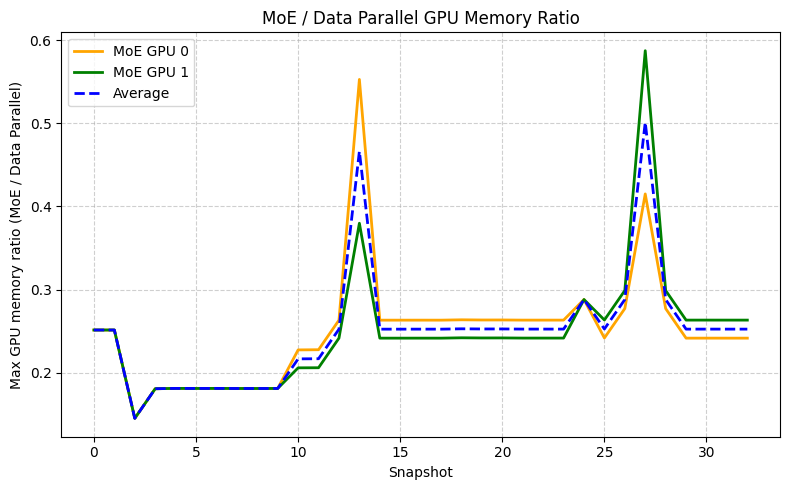

In [115]:
plot_gpu_memory_ratio(df)

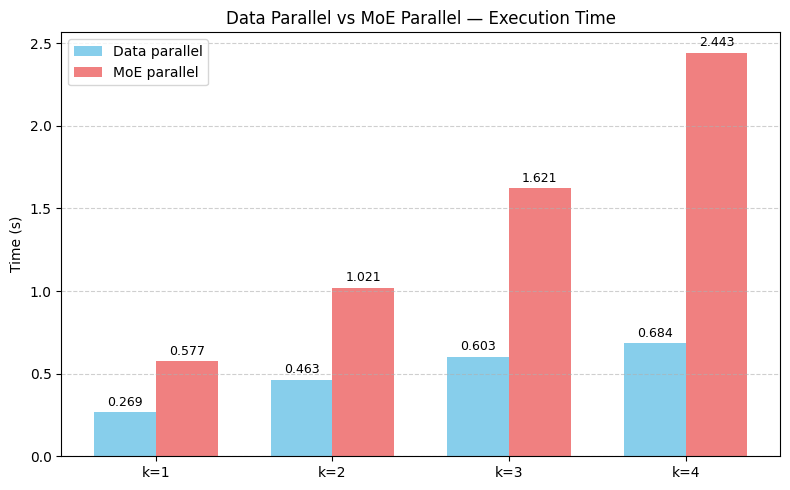

In [81]:
k = [1, 2, 3, 4]
values = [
    [0.269, 0.577],
    [0.463, 1.021],
    [0.603, 1.621],
    [0.684, 2.443]
]

plot_k_time(k, values)


## Равномерное распределение

In [116]:
df = pd.read_csv("results.csv")
df['time'] = df['time'] - df['time'].iloc[0]

In [117]:
df

,name,time,memory_gpu_0,max_memory_gpu_0,memory_gpu_1,max_memory_gpu_1
0,start,0.000000,0.882998,0.883001,0.882998,0.883001
1,start forward,0.002570,0.509769,0.882999,0.509769,0.882999
2,full top k index,0.005700,0.510258,0.510261,0.510258,0.510261
3,final hidden states,0.007264,0.635259,0.635262,0.635259,0.635262
4,sort global ranks,0.025125,0.635993,0.636742,0.635993,0.636742
5,need indicies,0.028927,0.636116,0.636513,0.636116,0.636512
6,local sorted ranks,0.032063,0.636361,0.636740,0.636361,0.636740
7,bincount,0.056085,0.636363,0.636365,0.636362,0.636364
8,recv counts,0.057253,0.636364,0.636366,0.636364,0.636366
9,counts.tolist,0.060107,0.636364,0.636503,0.636364,0.636502


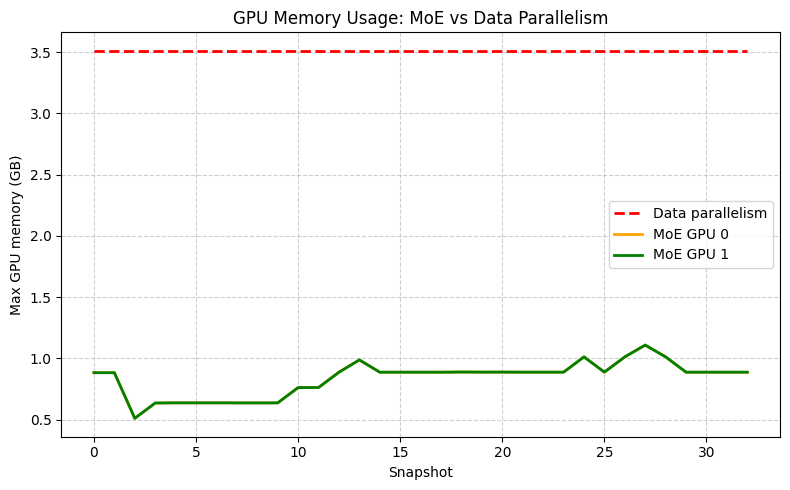

In [118]:
plot_gpu_memory(df)

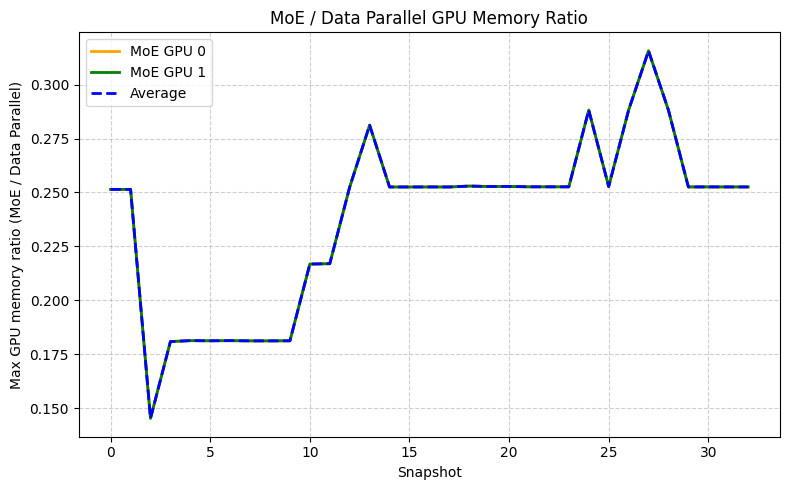

In [119]:
plot_gpu_memory_ratio(df)

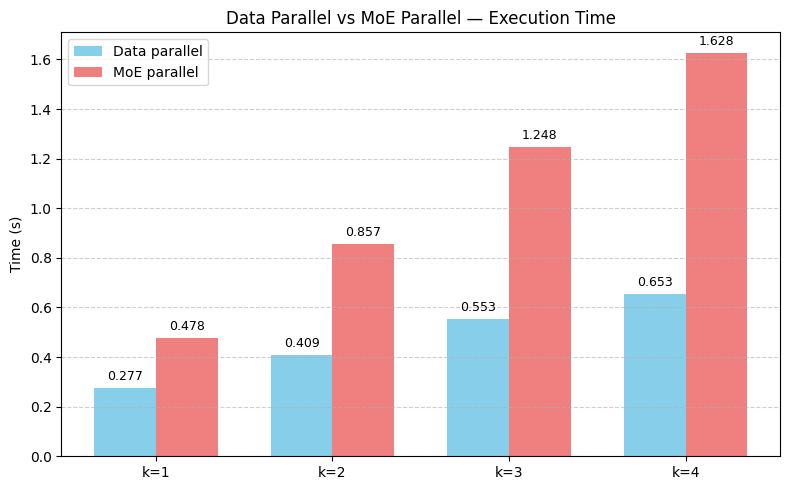

In [87]:
k = [1, 2, 3, 4]
values = [
    [0.277, 0.478],
    [0.409, 0.857],
    [0.553, 1.248],
    [0.653, 1.628]
]

plot_k_time(k, values)


## Spend Time

In [168]:
df = pd.read_csv("results.csv")
df['time'] = df['time'] - df['time'].iloc[0]
df['time'] = df['time'].diff()
df_mean = df.groupby("name", as_index=False).mean(numeric_only=True)

In [169]:
df_mean = df_mean.dropna().sort_values('time')

In [170]:
df_mean

,name,time,memory_gpu_0,max_memory_gpu_0,memory_gpu_1,max_memory_gpu_1
4,get expert mask,0.001576,0.864055,0.964456,0.863701,0.963712
9,sort local ranks,0.002058,0.839169,0.839744,0.838778,0.839353
6,mul by weights,0.002384,0.889059,0.889120,0.888705,0.888766
0,add to the output,0.003365,0.889060,0.889062,0.888706,0.888708
8,sort global ranks,0.004679,0.839095,0.840235,0.838704,0.839844
5,get send and recv lists,0.005755,0.838975,0.839199,0.838584,0.838808
3,full top k index,0.006861,0.512088,0.882999,0.512088,0.882999
7,second all2all,0.105317,0.889058,0.989059,0.888704,0.988704
2,first all2all,0.116703,0.864056,0.989056,0.863702,0.988702
1,compute,0.152812,0.864057,1.087539,0.863703,1.085796


/tmp/ipykernel_1749/4034466072.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(df))(np.arange(len(df)))


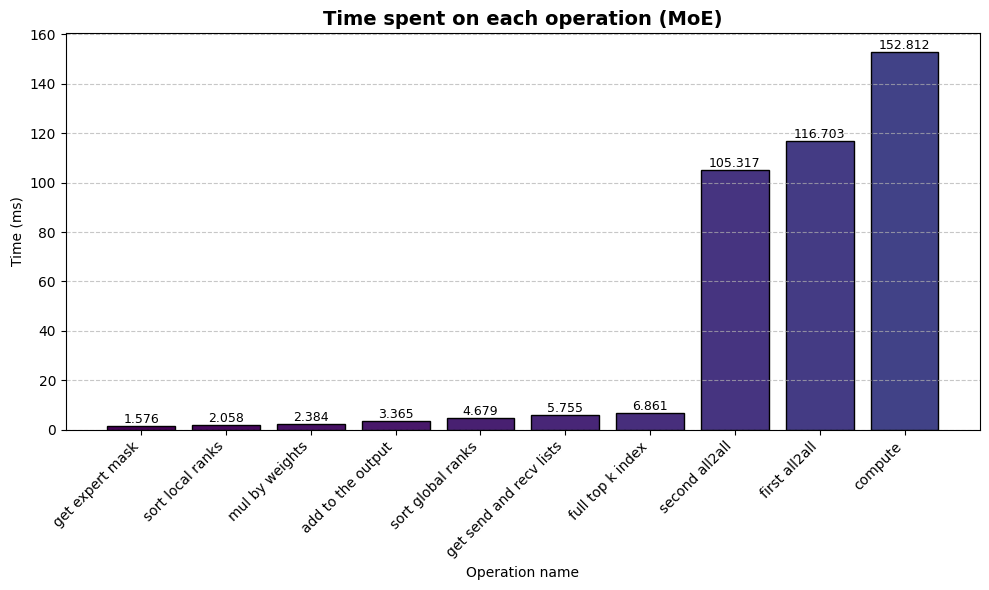

In [ ]:
name = df_mean['name']
time = (df_mean['time'] * (10**3))

plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('viridis', len(df))(np.arange(len(df)))

bars = plt.bar(name, time, color=colors, edgecolor='black')
for bar, value in zip(bars, time):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.001,
             f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.title('Time spent on each operation (MoE)', fontsize=14, fontweight='bold')
plt.ylabel('Time (ms)')
plt.xlabel('Operation name')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Выводы:**

1. В целом, MoE оказался хорошо реализован
2. Коммуникации занимают значительную часть времени инференса => нужно это как-то фиксить
3. На память очень сильно влияет распределение токенов по экспертам